In [1]:
pip install pennylane


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.1/57.1 kB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 35.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 930.8/930.8 kB 43.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 96.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 83.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 167.9/167.9 kB 13.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 114.8 MB/s eta 0:00:00



--- Configure Your Thruster Optimization ---
Enter target thrust [2.0]: 2
Enter target Isp [2000]: 2000
Enter target efficiency (0-1) [0.6]: 0.6
Enter target erosion rate [0.5]: 0.6

Enter qubits for B-Field [3]: 3
Enter qubits for Voltage [3]: 3
Enter qubits for Propellant Flow [2]: 2
Enter qubits for Material Choice [2]: 2

--- ThrusterModel Initialized ---
  - Target Thrust: 2.0
  - Target Isp: 2000.0
  - Target Efficiency: 0.6
  - Target Erosion Rate: 0.6


=== STARTING QUANTUM HYPERPARAMETER SEARCH ===

Initializing QuantumOptimizer with 10 qubits...
  - Building Hamiltonian...
  - Hamiltonian constructed in 0.01 seconds.
--- Running VQE (Layers: 1, Step Size: 0.1) ---
  Iteration  20: Hamiltonian Expectation = -0.97763740
  Iteration  40: Hamiltonian Expectation = -0.98257895
  Iteration  60: Hamiltonian Expectation = -0.98607958
  Iteration  80: Hamiltonian Expectation = -0.98754670
  Convergence reached at iteration 80.
--- Optimization Finished ---
  > Run (Layers=1, Step=0.1

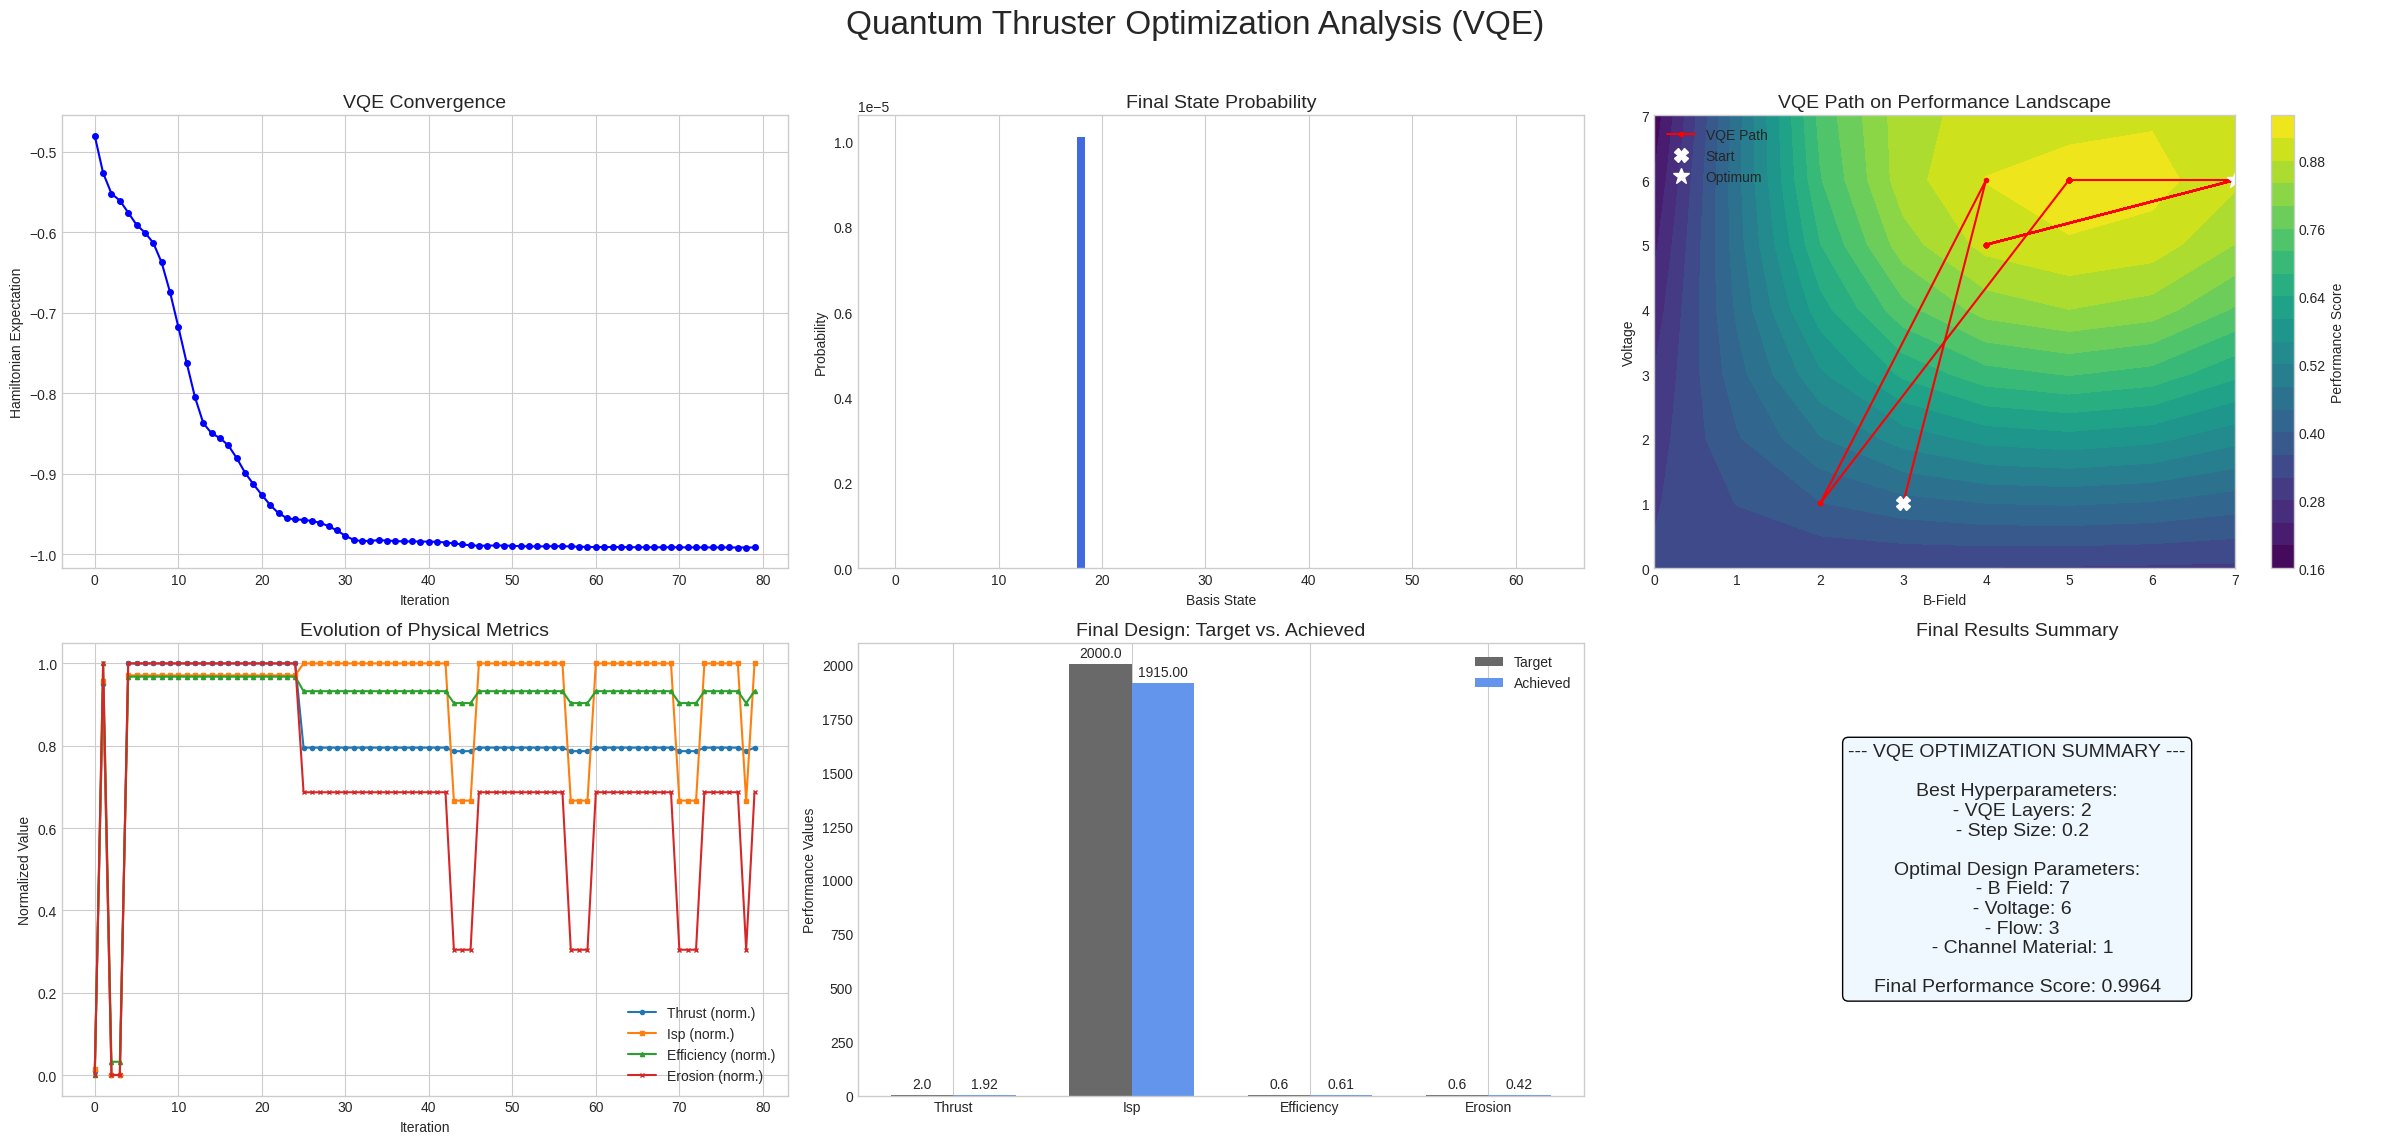



=== STARTING SURROGATE-BASED OPTIMIZATION ===

Initializing SurrogateOptimizer...
  - Generating 15 initial data points for surrogate training...
--- Running Bayesian Optimization ---
  Iteration  5: Best Performance Found = 0.9533
  Iteration 10: Best Performance Found = 0.9533
  Iteration 15: Best Performance Found = 0.9888
  Iteration 20: Best Performance Found = 0.9888
  Iteration 25: Best Performance Found = 0.9888
--- Bayesian Optimization Finished ---

Visualizing the results of the surrogate-based run...


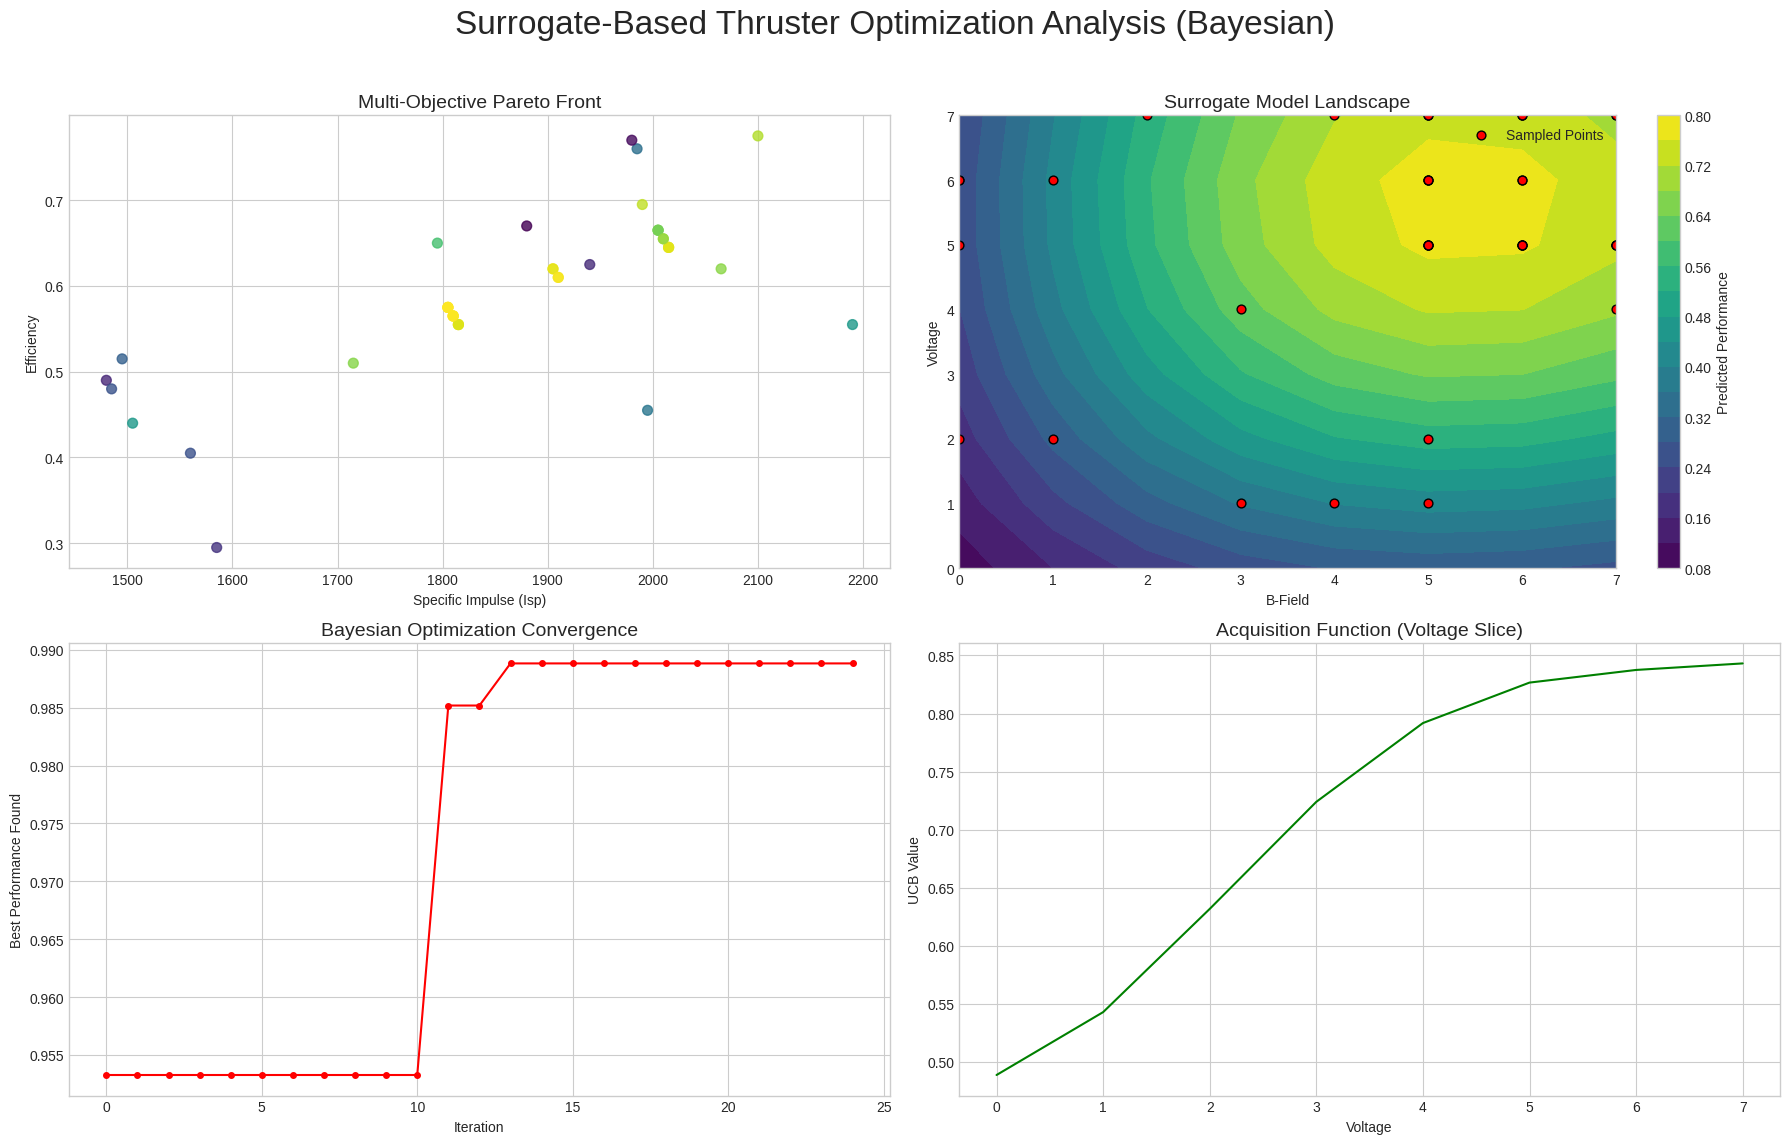

In [2]:
# --- Required Installations ---
# Before running, ensure you have the necessary libraries installed.
# You can install them using pip in your terminal:
# pip install pennylane matplotlib scikit-learn

import pennylane as qml
from pennylane import numpy as np
import matplotlib.pyplot as plt
import itertools
import time
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C
from scipy.stats import norm

# --- 1. Classical Physics Model ---
# This class acts as our "real world" simulation oracle.

class ThrusterModel:
    """
    Encapsulates the classical performance metric for the plasma thruster.
    This model simulates a performance score based on physical parameters,
    including material choice and its effect on erosion.
    """
    def __init__(self, target_thrust, target_isp, target_efficiency, target_erosion_rate):
        self.target_thrust = target_thrust
        self.target_isp = target_isp
        self.target_efficiency = target_efficiency
        self.target_erosion_rate = target_erosion_rate # Lower is better

        self.material_erosion_factors = {
            0: 1.0, 1: 0.7, 2: 0.4, 3: 0.25
        }

        print("\n--- ThrusterModel Initialized ---")
        print(f"  - Target Thrust: {target_thrust}")
        print(f"  - Target Isp: {target_isp}")
        print(f"  - Target Efficiency: {target_efficiency}")
        print(f"  - Target Erosion Rate: {target_erosion_rate}")

    def _calculate_physics(self, params):
        """A simplified physics model to get performance values."""
        b = params['b_field']
        v = params['voltage']
        f = params['flow']
        mat_index = params['channel_material']
        material_factor = self.material_erosion_factors.get(mat_index, 1.0)
        erosion_rate = 0.1 * v * material_factor
        efficiency_degradation = 0.05 * erosion_rate
        thrust = (v / 10.0) * (f + 1) * (1 - 0.05 * (b - 5)**2)
        isp = 1500 + 100 * v - 20 * f**2 - 5 * abs(b - 8)
        efficiency = (0.5 + 0.05 * v - 0.1 * abs(f - 2) - 0.01 * b) - efficiency_degradation
        return thrust, isp, efficiency, erosion_rate

    def calculate_performance(self, params):
        """Calculates a single performance score for a given set of thruster parameters."""
        thrust, isp, efficiency, erosion_rate = self._calculate_physics(params)
        error_thrust = ((thrust - self.target_thrust) / self.target_thrust)**2
        error_isp = ((isp - self.target_isp) / self.target_isp)**2
        error_efficiency = ((efficiency - self.target_efficiency) / self.target_efficiency)**2
        error_erosion = ((erosion_rate - self.target_erosion_rate) / self.target_erosion_rate)**2 if erosion_rate > self.target_erosion_rate else 0
        total_error = error_thrust + error_isp + error_efficiency + error_erosion
        return np.exp(-total_error)

# --- 2. Quantum Optimization Framework ---
class QuantumOptimizer:
    """ Manages the VQE optimization process for the thruster model. """
    def __init__(self, model, config):
        self.model = model
        self.config = config
        self.n_qubits = sum(config['bits_map'].values())
        self.dev = qml.device("default.qubit", wires=self.n_qubits)
        print(f"\nInitializing QuantumOptimizer with {self.n_qubits} qubits...")
        print("  - Building Hamiltonian...")
        start_time = time.time()
        self.hamiltonian = self._build_hamiltonian_efficiently()
        print(f"  - Hamiltonian constructed in {time.time() - start_time:.2f} seconds.")

    def _build_hamiltonian_efficiently(self):
        """Constructs a diagonal Hamiltonian where energies are -performance."""
        num_states = 2**self.n_qubits
        energies = np.zeros(num_states)
        for i in range(num_states):
            params = self._index_to_params(i)
            energies[i] = -self.model.calculate_performance(params)
        return qml.Hermitian(np.diag(energies), wires=range(self.n_qubits))

    def run_vqe(self):
        """Executes the main VQE optimization loop."""
        print(f"--- Running VQE (Layers: {self.config['n_layers']}, Step Size: {self.config['step_size']}) ---")
        @qml.qnode(self.dev)
        def circuit(weights):
            qml.StronglyEntanglingLayers(weights, wires=range(self.n_qubits))
            return qml.expval(self.hamiltonian)

        optimizer = self.config['optimizer'](stepsize=self.config['step_size'])
        weights_shape = qml.StronglyEntanglingLayers.shape(n_layers=self.config['n_layers'], n_wires=self.n_qubits)
        weights = np.random.uniform(0, 2 * np.pi, size=weights_shape)
        expval_history, params_history = [], []

        for i in range(self.config['max_iterations']):
            weights, expval = optimizer.step_and_cost(circuit, weights)
            expval_history.append(expval)
            probs = self.get_probabilities(weights)
            params_history.append(self._index_to_params(np.argmax(probs)))
            if (i + 1) % 20 == 0:
                print(f"  Iteration {i+1:3d}: Hamiltonian Expectation = {expval:.8f}")
            if len(expval_history) > 1 and np.abs(expval_history[-1] - expval_history[-2]) < self.config['conv_tol']:
                print(f"  Convergence reached at iteration {i+1}.")
                break
        print("--- Optimization Finished ---")
        return weights, expval_history, params_history

    def get_probabilities(self, weights):
        @qml.qnode(self.dev)
        def prob_circuit(w):
            qml.StronglyEntanglingLayers(w, wires=range(self.n_qubits))
            return qml.probs(wires=range(self.n_qubits))
        return prob_circuit(weights)

    def _index_to_params(self, index):
        params = {}
        bitstring = format(index, f'0{self.n_qubits}b')
        current_idx = 0
        for name, n_bits in self.config['bits_map'].items():
            params[name] = int(bitstring[current_idx : current_idx + n_bits], 2)
            current_idx += n_bits
        return params

# --- 3. Surrogate Modeling & Bayesian Optimization Framework ---
class SurrogateOptimizer:
    """ Manages surrogate-based optimization using classical ML. """
    def __init__(self, model, param_space, n_initial_points=10):
        self.model = model
        self.param_space = param_space
        self.n_initial_points = n_initial_points

        kernel = C(1.0, (1e-3, 1e3)) * RBF(length_scale=1.0, length_scale_bounds=(1e-2, 1e2))
        self.surrogate = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=9, alpha=1e-2)

        self.X_samples = []
        self.Y_samples = []
        self.best_performance_history = []
        print("\nInitializing SurrogateOptimizer...")

    def _generate_initial_data(self):
        """Generates the first batch of data to train the surrogate."""
        print(f"  - Generating {self.n_initial_points} initial data points for surrogate training...")
        for _ in range(self.n_initial_points):
            params_vec = [np.random.choice(vals) for vals in self.param_space.values()]
            self.X_samples.append(params_vec)

            params_dict = dict(zip(self.param_space.keys(), params_vec))
            performance = self.model.calculate_performance(params_dict)
            self.Y_samples.append(performance)

        self.X_samples = np.array(self.X_samples)
        self.Y_samples = np.array(self.Y_samples)

    def _acquisition_function(self, X_grid, kappa=2.576):
        """Upper Confidence Bound (UCB) acquisition function."""
        mean, std = self.surrogate.predict(X_grid, return_std=True)
        return mean + kappa * std

    def run_optimization(self, n_iterations=20):
        """Runs the main Bayesian Optimization loop."""
        self._generate_initial_data()

        # Create a grid of all possible parameter combinations to search over
        param_combinations = list(itertools.product(*self.param_space.values()))
        X_grid = np.array(param_combinations)

        print("--- Running Bayesian Optimization ---")
        for i in range(n_iterations):
            self.surrogate.fit(self.X_samples, self.Y_samples)

            # Find next point to sample
            ucb_values = self._acquisition_function(X_grid)
            next_point_idx = np.argmax(ucb_values)
            next_point_vec = X_grid[next_point_idx]

            # Evaluate the true model at the new point
            params_dict = dict(zip(self.param_space.keys(), next_point_vec))
            performance = self.model.calculate_performance(params_dict)

            # Add new sample to dataset
            self.X_samples = np.vstack([self.X_samples, next_point_vec])
            self.Y_samples = np.append(self.Y_samples, performance)

            self.best_performance_history.append(np.max(self.Y_samples))
            if (i+1) % 5 == 0:
                 print(f"  Iteration {i+1:2d}: Best Performance Found = {self.best_performance_history[-1]:.4f}")

        print("--- Bayesian Optimization Finished ---")
        return self.X_samples, self.Y_samples, self.best_performance_history

# --- 4. Visualization Suites ---
class QuantumResultVisualizer:
    """ Handles visualization for the quantum VQE results. """
    def __init__(self, model, config, expval_history, probabilities, params_history, final_performance):
        self.model, self.config, self.expval_history, self.probabilities, self.params_history, self.final_performance = \
            model, config, expval_history, probabilities, params_history, final_performance
        self.n_qubits = sum(config['bits_map'].values())
        plt.style.use('seaborn-v0_8-whitegrid')

    def plot_all(self):
        fig, axs = plt.subplots(2, 3, figsize=(24, 12))
        fig.suptitle('Quantum Thruster Optimization Analysis (VQE)', fontsize=24)
        self._plot_convergence(axs[0, 0])
        self._plot_probability_distribution(axs[0, 1])
        self._plot_performance_landscape(axs[0, 2])
        self._plot_metrics_evolution(axs[1, 0])
        self._plot_final_performance_comparison(axs[1, 1])
        self._display_text_summary(axs[1, 2])
        plt.tight_layout(rect=[0, 0.03, 1, 0.96])
        plt.show()

    def _plot_convergence(self, ax):
        ax.plot(self.expval_history, 'b-o', markersize=4)
        ax.set_title('VQE Convergence', fontsize=14)
        ax.set_xlabel('Iteration'); ax.set_ylabel('Hamiltonian Expectation'); ax.grid(True)

    def _plot_probability_distribution(self, ax):
        num_states = min(2**self.n_qubits, 64)
        ax.bar(range(num_states), self.probabilities[:num_states], color='royalblue')
        ax.set_title('Final State Probability', fontsize=14)
        ax.set_xlabel('Basis State'); ax.set_ylabel('Probability'); ax.grid(axis='y')

    def _plot_performance_landscape(self, ax):
        b_bits, v_bits = self.config['bits_map']['b_field'], self.config['bits_map']['voltage']
        b_range, v_range = np.arange(2**b_bits), np.arange(2**v_bits)
        b_grid, v_grid = np.meshgrid(b_range, v_range)
        grid = np.zeros_like(b_grid, dtype=float)
        flow = int(2**(self.config['bits_map']['flow'] / 2))
        mat = int(2**(self.config['bits_map']['channel_material'] / 2))
        for i, j in itertools.product(range(b_grid.shape[0]), range(b_grid.shape[1])):
            params = {'b_field': b_grid[i, j], 'voltage': v_grid[i, j], 'flow': flow, 'channel_material': mat}
            grid[i, j] = self.model.calculate_performance(params)
        contour = ax.contourf(b_grid, v_grid, grid, levels=20, cmap='viridis')
        plt.colorbar(contour, ax=ax, label='Performance Score')
        path_b = [p['b_field'] for p in self.params_history]
        path_v = [p['voltage'] for p in self.params_history]
        ax.plot(path_b, path_v, 'r-o', markersize=3, label='VQE Path')
        ax.plot(path_b[0], path_v[0], 'wX', markersize=10, label='Start')
        ax.plot(path_b[-1], path_v[-1], 'w*', markersize=12, label='Optimum')
        ax.set_title('VQE Path on Performance Landscape', fontsize=14)
        ax.set_xlabel('B-Field'); ax.set_ylabel('Voltage'); ax.legend()

    def _plot_metrics_evolution(self, ax):
        iters = range(len(self.params_history))
        hists = [[], [], [], []]
        for params in self.params_history:
            vals = self.model._calculate_physics(params)
            for i in range(4): hists[i].append(vals[i])
        def normalize(arr):
            arr = np.array(arr); min_v, max_v = arr.min(), arr.max()
            return (arr - min_v) / (max_v - min_v) if max_v != min_v else np.ones_like(arr)
        labels = ['Thrust', 'Isp', 'Efficiency', 'Erosion']
        markers = ['o', 's', '^', 'x']
        for i, label in enumerate(labels):
            ax.plot(iters, normalize(hists[i]), label=f'{label} (norm.)', marker=markers[i], markersize=3)
        ax.set_title('Evolution of Physical Metrics', fontsize=14)
        ax.set_xlabel('Iteration'); ax.set_ylabel('Normalized Value'); ax.legend(); ax.grid(True)

    def _plot_final_performance_comparison(self, ax):
        labels = ['Thrust', 'Isp', 'Efficiency', 'Erosion']
        targets = [self.model.target_thrust, self.model.target_isp, self.model.target_efficiency, self.model.target_erosion_rate]
        achieved = self.model._calculate_physics(self.params_history[-1])
        x, width = np.arange(len(labels)), 0.35
        rects1 = ax.bar(x - width/2, targets, width, label='Target', color='dimgray')
        rects2 = ax.bar(x + width/2, achieved, width, label='Achieved', color='cornflowerblue')
        ax.set_ylabel('Performance Values'); ax.set_title('Final Design: Target vs. Achieved', fontsize=14)
        ax.set_xticks(x); ax.set_xticklabels(labels); ax.legend()
        ax.bar_label(rects1, padding=3, fmt='%.1f'); ax.bar_label(rects2, padding=3, fmt='%.2f'); ax.grid(axis='y')

    def _display_text_summary(self, ax):
        ax.axis('off')
        params = self.params_history[-1]
        text = f"--- VQE OPTIMIZATION SUMMARY ---\n\nBest Hyperparameters:\n  - VQE Layers: {self.config['n_layers']}\n  - Step Size: {self.config['step_size']}\n\n"
        text += "Optimal Design Parameters:\n"
        for name, val in params.items(): text += f"  - {name.replace('_', ' ').title()}: {val}\n"
        text += f"\nFinal Performance Score: {self.final_performance:.4f}"
        ax.text(0.5, 0.5, text, ha='center', va='center', fontsize=14, bbox=dict(boxstyle="round", fc="aliceblue"))
        ax.set_title('Final Results Summary', fontsize=14)

class SurrogateResultVisualizer:
    """ Handles visualization for the surrogate-based optimization results. """
    def __init__(self, optimizer):
        self.optimizer = optimizer
        self.model = optimizer.model
        plt.style.use('seaborn-v0_8-whitegrid')

    def plot_all(self):
        fig, axs = plt.subplots(2, 2, figsize=(18, 12))
        fig.suptitle('Surrogate-Based Thruster Optimization Analysis (Bayesian)', fontsize=24)
        self._plot_pareto_front(axs[0, 0])
        self._plot_surrogate_landscape(axs[0, 1])
        self._plot_convergence(axs[1, 0])
        self._plot_acquisition_function(axs[1, 1])
        plt.tight_layout(rect=[0, 0.03, 1, 0.96])
        plt.show()

    def _plot_pareto_front(self, ax):
        """Plots the trade-off between two objectives, e.g., Efficiency and Isp."""
        physics_data = [self.model._calculate_physics(dict(zip(self.optimizer.param_space.keys(), x))) for x in self.optimizer.X_samples]
        isps = [p[1] for p in physics_data]
        efficiencies = [p[2] for p in physics_data]
        ax.scatter(isps, efficiencies, c=self.optimizer.Y_samples, cmap='viridis', s=50, alpha=0.8)
        ax.set_title('Multi-Objective Pareto Front', fontsize=14)
        ax.set_xlabel('Specific Impulse (Isp)')
        ax.set_ylabel('Efficiency')
        ax.grid(True)

    def _plot_surrogate_landscape(self, ax):
        """Plots the surrogate's prediction and uncertainty."""
        param_space = self.optimizer.param_space
        b_range = param_space['b_field']
        v_range = param_space['voltage']
        b_grid, v_grid = np.meshgrid(b_range, v_range)

        # Use representative flow and material
        flow = int(np.median(param_space['flow']))
        mat = int(np.median(param_space['channel_material']))

        grid_points = []
        for b, v in zip(b_grid.ravel(), v_grid.ravel()):
            grid_points.append([b, v, flow, mat])

        mean, std = self.optimizer.surrogate.predict(grid_points, return_std=True)
        mean_grid = mean.reshape(b_grid.shape)

        contour = ax.contourf(b_grid, v_grid, mean_grid, levels=20, cmap='viridis')
        plt.colorbar(contour, ax=ax, label='Predicted Performance')
        ax.scatter(self.optimizer.X_samples[:, 0], self.optimizer.X_samples[:, 1], c='red', s=40, edgecolor='black', label='Sampled Points')
        ax.set_title('Surrogate Model Landscape', fontsize=14)
        ax.set_xlabel('B-Field'); ax.set_ylabel('Voltage'); ax.legend()

    def _plot_convergence(self, ax):
        ax.plot(self.optimizer.best_performance_history, 'r-o', markersize=4)
        ax.set_title('Bayesian Optimization Convergence', fontsize=14)
        ax.set_xlabel('Iteration'); ax.set_ylabel('Best Performance Found'); ax.grid(True)

    def _plot_acquisition_function(self, ax):
        """Visualizes where the optimizer wants to sample next."""
        param_space = self.optimizer.param_space
        param_combinations = list(itertools.product(*param_space.values()))
        X_grid = np.array(param_combinations)

        # For a 1D slice visualization
        v_slice_points = [p for p in X_grid if p[0] == int(np.median(param_space['b_field'])) and p[2] == int(np.median(param_space['flow'])) and p[3] == int(np.median(param_space['channel_material']))]
        v_slice_points = np.array(v_slice_points)

        if len(v_slice_points) > 0:
            acq_values = self.optimizer._acquisition_function(v_slice_points)
            voltages = v_slice_points[:, 1]
            ax.plot(voltages, acq_values, 'g-', label='UCB')
            ax.set_title('Acquisition Function (Voltage Slice)', fontsize=14)
            ax.set_xlabel('Voltage'); ax.set_ylabel('UCB Value'); ax.grid(True)


# --- 5. Main Execution Block ---
def get_user_input():
    print("\n--- Configure Your Thruster Optimization ---")
    targets, bits_map = {}, {}
    targets['thrust'] = float(input("Enter target thrust [2.0]: ") or 2.0)
    targets['isp'] = float(input("Enter target Isp [2000]: ") or 2000)
    targets['efficiency'] = float(input("Enter target efficiency (0-1) [0.6]: ") or 0.6)
    targets['erosion'] = float(input("Enter target erosion rate [0.5]: ") or 0.5)
    bits_map['b_field'] = int(input("\nEnter qubits for B-Field [3]: ") or 3)
    bits_map['voltage'] = int(input("Enter qubits for Voltage [3]: ") or 3)
    bits_map['flow'] = int(input("Enter qubits for Propellant Flow [2]: ") or 2)
    bits_map['channel_material'] = int(input("Enter qubits for Material Choice [2]: ") or 2)
    return targets, bits_map

if __name__ == "__main__":
    targets, bits_map = get_user_input()

    # --- Run Quantum VQE Workflow ---
    BASE_CONFIG = {'bits_map': bits_map, 'max_iterations': 80, 'conv_tol': 1e-6, 'optimizer': qml.AdamOptimizer}
    hyperparameter_space = {'n_layers': [1, 2], 'step_size': [0.1, 0.2]}
    total_qubits = sum(BASE_CONFIG['bits_map'].values())
    if total_qubits > 10: print(f"\nWARNING: Qubits ({total_qubits}) > 10. VQE will be slow.")

    thruster = ThrusterModel(targets['thrust'], targets['isp'], targets['efficiency'], targets['erosion'])
    best_run_vqe = {'final_performance': -float('inf')}

    print("\n\n=== STARTING QUANTUM HYPERPARAMETER SEARCH ===")
    for layers, step in itertools.product(hyperparameter_space['n_layers'], hyperparameter_space['step_size']):
        run_config = {**BASE_CONFIG, 'n_layers': layers, 'step_size': step}
        optimizer = QuantumOptimizer(thruster, run_config)
        weights, exp_hist, params_hist = optimizer.run_vqe()
        probs = optimizer.get_probabilities(weights)
        optimal_params = optimizer._index_to_params(np.argmax(probs))
        final_perf = thruster.calculate_performance(optimal_params)
        print(f"  > Run (Layers={layers}, Step={step}): Max Performance = {final_perf:.4f}")
        if final_perf > best_run_vqe['final_performance']:
            print("  *** New best VQE result found! ***")
            best_run_vqe = {'config': run_config, 'final_performance': final_perf, 'optimal_params': optimal_params,
                            'expval_history': exp_hist, 'params_history': params_hist, 'probabilities': probs}

    print("\nVisualizing the results of the best VQE run...")
    vqe_viz = QuantumResultVisualizer(
        model=thruster,
        config=best_run_vqe['config'],
        expval_history=best_run_vqe['expval_history'],
        probabilities=best_run_vqe['probabilities'],
        params_history=best_run_vqe['params_history'],
        final_performance=best_run_vqe['final_performance']
    )
    vqe_viz.plot_all()

    # --- Run Surrogate-Based Classical Workflow ---
    print("\n\n=== STARTING SURROGATE-BASED OPTIMIZATION ===")
    param_space = {name: range(2**n_bits) for name, n_bits in bits_map.items()}
    surrogate_optimizer = SurrogateOptimizer(thruster, param_space, n_initial_points=15)
    X, Y, conv_hist = surrogate_optimizer.run_optimization(n_iterations=25)

    print("\nVisualizing the results of the surrogate-based run...")
    surrogate_viz = SurrogateResultVisualizer(surrogate_optimizer)
    surrogate_viz.plot_all()

